Import Data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_stata("callreports_final.dta", chunksize=100000, preserve_dtypes=True)

df_raw = pd.DataFrame()

for chunk in data:
    df_raw=df_raw.append(chunk)

Additional Settings

In [7]:
%matplotlib inline
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker

pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 18

plt.style.use('default')


plt.rcParams['font.size']=BIGGER_SIZE          # controls default text sizes
plt.rcParams['axes.titlesize']=BIGGER_SIZE     # fontsize of the axes title
plt.rcParams['axes.labelsize']=BIGGER_SIZE    # fontsize of the x and y labels
plt.rcParams['xtick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['ytick.labelsize']=BIGGER_SIZE    # fontsize of the tick labels
plt.rcParams['legend.fontsize']=BIGGER_SIZE    # legend fontsize
plt.rcParams['figure.titlesize']=BIGGER_SIZE  # fontsize of the figure title

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#removing Goldman Sachs and Morgan Stanley
df_raw = df_raw[(df_raw.rssdid!=1456501) & (df_raw.bhcid!=2380443)]

Get BHCs and independent commercial banks

In [8]:
df = df_raw[["name", "bhcid", "rssdid","assets",'year', "quarter", "equity"]]


df_indBanks = df[df.bhcid == 0]


df = df[df.bhcid != 0]
df = df.groupby(["bhcid","year", "quarter"]).agg({"assets":"sum",
                                  "equity":"sum"})

df["leverageRatio"] = df.assets/df.equity

#rename bhcid to rssdid
df.index.names = ["rssdid", "year", "quarter"]

df_indBanks["leverageRatio"] = df_indBanks.assets/df_indBanks.equity
df_indBanks.set_index([df_indBanks.rssdid, df_indBanks.year, df_indBanks.quarter], inplace=True)
df_indBanks = df_indBanks[["assets", "equity", "leverageRatio"]]
#df_indBanks.drop(["rssdid", "bhcid", "year"], axis=1, inplace=True)
#df
df_all_raw = pd.concat([df, df_indBanks])

In [9]:
df_all = df_all_raw.copy()
df_all.leverageRatio.replace([np.inf, -np.inf], np.nan, inplace=True)
df_all.dropna(how="all", subset=["leverageRatio"],inplace=True)

df_all = df_all[df_all.leverageRatio>0] #removing all negativ leverageRatios
df_all_noIndex = df_all.reset_index()
df_all_noIndex

,rssdid,year,quarter,assets,equity,leverageRatio
0,128146.0,1976.0,1.0,10986.0,956.0,11.491632
1,128146.0,1976.0,2.0,11870.0,1030.0,11.524272
2,128146.0,1976.0,3.0,11410.0,1061.0,10.754006
3,128146.0,1976.0,4.0,11559.0,1049.0,11.019066
4,128146.0,1977.0,1.0,11936.0,1068.0,11.176030
...,...,...,...,...,...,...
1312394,4262543.0,2013.0,2.0,742574.0,168484.0,4.407386
1312395,4262543.0,2013.0,3.0,770830.0,170330.0,4.525509
1312396,4262543.0,2013.0,4.0,808999.0,168617.0,4.797850
1312397,4536084.0,2013.0,4.0,35356.0,15989.0,2.211270


In [18]:
def create_weighted_leverage(data):
    data["weigh_leverage"] = data["leverageRatio"] * (data["assets"]/data["assets"].sum())
    data = data.sum()
    return data

df_grouped = df_all_noIndex.groupby(["year", "quarter"]).apply(create_weighted_leverage)

df_grouped



rssdid        year  quarter        assets        equity  leverageRatio  weigh_leverage
year   quarter                                                                                              
1976.0 1.0      7.427315e+09  24626888.0  12463.0  1.073568e+09  6.751374e+07  157809.384019       17.781265
       2.0      7.447874e+09  24660480.0  24960.0  1.105073e+09  6.933982e+07  156665.186514       17.748200
       3.0      7.454002e+09  24638744.0  37407.0  1.119128e+09  7.088577e+07  154312.578652       17.390201
       4.0      7.487194e+09  24680240.0  49960.0  1.185681e+09  7.245466e+07  160088.142337       17.989507
1977.0 1.0      7.508265e+09  24706569.0  12497.0  1.189647e+09  7.383850e+07  157095.318357       17.661233
       2.0      7.526738e+09  24742155.0  25030.0  1.232057e+09  7.588314e+07  157800.350029       17.909971
       3.0      7.521668e+09  24686799.0  37461.0  1.267504e+09  7.786692e+07  154256.188076       17.876910
       4.0      7.551553e+09  24718431.0  50012.0  1.342867e+09  7.946025e+07  162009.285393       18.525241
1978.0 1.0      7.554629e+09  24661704.0  12468.0  1.342692e+09  8.117627e+07  156808.688078       18.162561
       2.0      7.583104e+09  24671594.0  24946.0  1.396911e+09  8.324658e+07  157751.232646       18.469862
       3.0      7.612256e+09  24667638.0  37413.0  1.429787e+09  8.573876e+07  154770.905971       18.432796
       4.0      7.642684e+09  24639946.0  49828.0  1.507722e+09  8.738327e+07  160752.479126       19.113607
1979.0 1.0      7.674464e+09  24660319.0  12461.0  1.507312e+09  8.967047e+07  154075.557506       18.681307
       2.0      7.717223e+09  24690004.0  24952.0  1.574253e+09  9.246108e+07  153454.985062       18.921370
       3.0      7.766792e+09  24731563.0  37491.0  1.638521e+09  9.524076e+07  150729.559900       19.253980
       4.0      7.811921e+09  24701878.0  49928.0  1.691411e+09  9.713720e+07  154513.000099       19.386356
1980.0 1.0      7.881113e+09  24704460.0  12477.0  1.700178e+09  9.986013e+07  149022.917751       19.013970
       2.0      7.941929e+09  24660900.0  24910.0  1.745143e+09  1.024170e+08  147256.043327       19.099887
       3.0      8.001937e+09  24621300.0  37305.0  1.780277e+09  1.053185e+08  146645.910216       18.880811
       4.0      8.109102e+09  24546060.0  49588.0  1.855152e+09  1.074653e+08  149885.528632       19.231610
1981.0 1.0      8.164962e+09  24526761.0  12381.0  1.873581e+09  1.108996e+08  146002.421087       18.881830
       2.0      8.221307e+09  24449502.0  24684.0  1.927426e+09  1.135731e+08  143973.314095       19.071641
       3.0      8.300428e+09  24390072.0  36936.0  1.966118e+09  1.164777e+08  141534.691284       19.101718
       4.0      8.383418e+09  24241497.0  48948.0  2.028781e+09  1.182110e+08  148446.584746       19.057715
1982.0 1.0      8.470776e+09  24158598.0  12189.0  2.031751e+09  1.211452e+08  144853.306892       18.577064
       2.0      8.558658e+09  24051570.0  24270.0  2.069759e+09  1.236441e+08  142466.405237       18.607727
       3.0      8.641389e+09  23936614.0  36231.0  2.112869e+09  1.267192e+08  140105.255234       18.533127
       4.0      8.716450e+09  23766162.0  47964.0  2.192717e+09  1.286353e+08  145477.672545       18.846475
1983.0 1.0      8.802224e+09  23657190.0  11930.0  2.189188e+09  1.320820e+08  141303.074540       18.218029
       2.0      8.902801e+09  23599683.0  23802.0  2.238695e+09  1.349355e+08  143639.116247       18.558875
       3.0      8.969430e+09  23464839.0  35499.0  2.254814e+09  1.377538e+08  142198.152706       19.112692
       4.0      9.009340e+09  23214981.0  46828.0  2.337469e+09  1.401432e+08  144867.529291       18.238077
1984.0 1.0      9.066912e+09  23113600.0  11650.0  2.355120e+09  1.434661e+08  142415.483856       17.865084
       2.0      9.111023e+09  22939008.0  23124.0  2.409268e+09  1.460952e+08  140490.165713       18.069763
       3.0      9.168885e+09  22837824.0  34533.0  2.414417e+09  1.509331e+08  136878.862327      

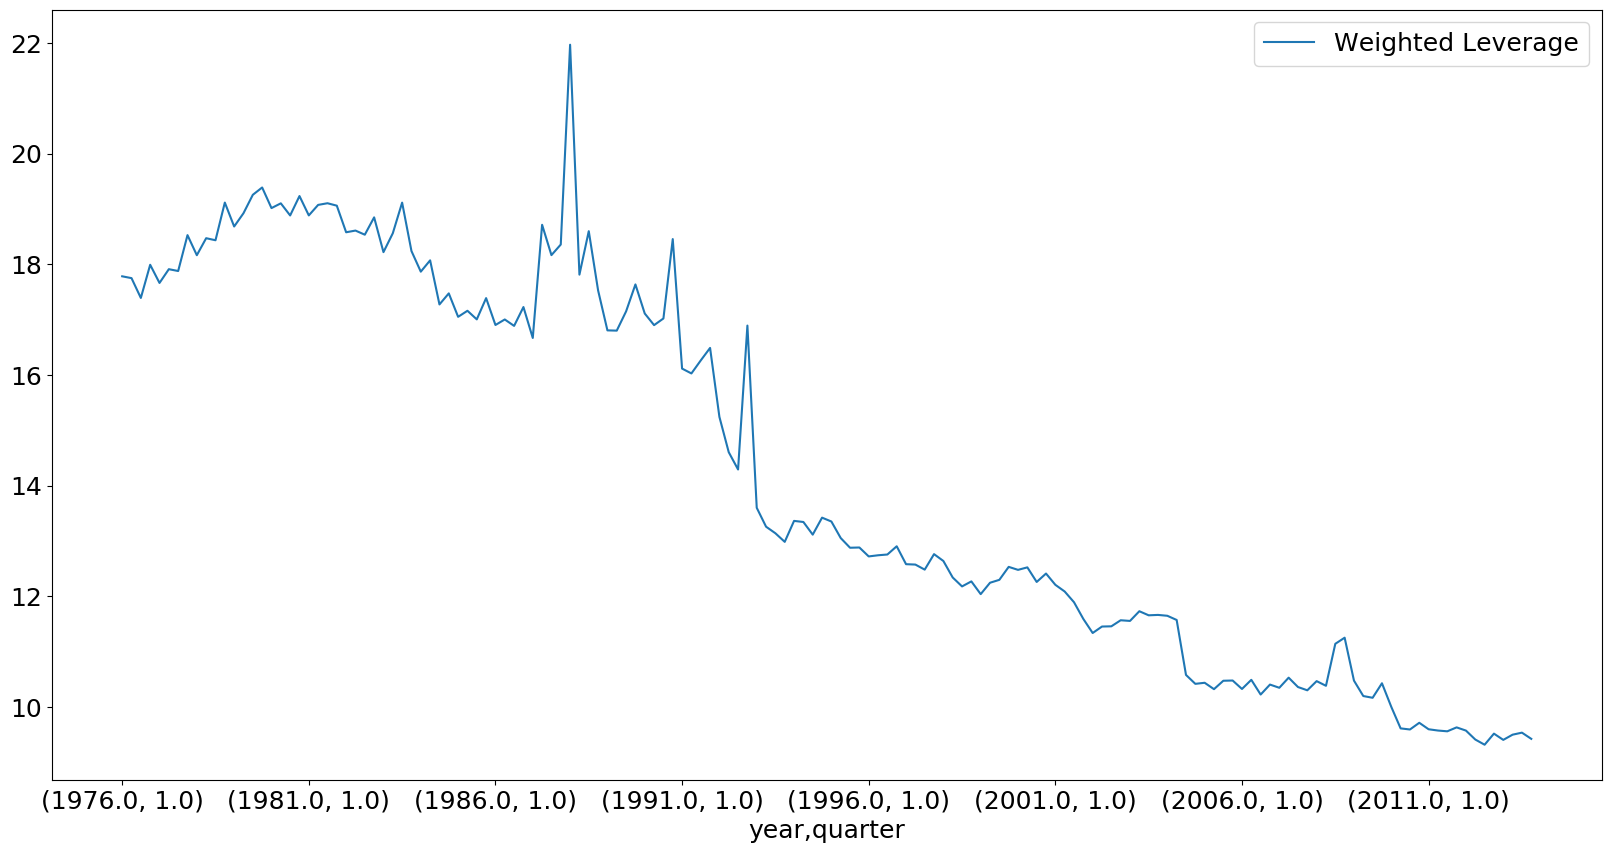

In [26]:
fig, ax = plt.subplots(figsize=(20,10))

df_grouped.plot(ax=ax, y=["weigh_leverage"])

#plot settings
ax.legend(["Weighted Leverage"])